In [1]:
# if necessary, install NeuralGCM and dependencies
!python --version
!pip install -q -U neuralgcm dinosaur-dycore gcsfs
!pip install matplotlib
!pip install cartopy
!pip install xarray netCDF4 numpy

Python 3.11.10


## Background and Motivation

<span style="color:blue">Todo later</span> Rewrite Introduction, add any relevant thins into here
Droughts are natural disasters that are getting worse every year and therefore affecting millions of people by increasing the risk of malnutrition, diseases, wildfires, or forced migration due to droughts. Developing early warning systems and timely interventions is crucial to mitigate the economic, social, and environmental impacts of droughts.



<span style="color:blue"> Add other necessary information

## Data and Objectives

Todo: Add if something is missing
Data: \
ERA 5 data \
pretrained NeuralGCM model (intermediate deterministic NeuralGCM 1.4 model) \
SST data 

Objectives: \
The aim of this project is to make a 30-year roll-out prediction for drought frequency and amplitudes in the region of Spain. 

## Drought specific variables

Evapotranspiration (not in NeuralGCM) \
Precipitation (not in NeuralGCM) \
Temperature \
Specific_humidity \
Sea Surface Temperature (not in NeuralGCM)

In [33]:
import gin
gin.enter_interactive_mode()
import gcsfs
import jax
import numpy as np
import pickle
import xarray as xr

from dinosaur import horizontal_interpolation
from dinosaur import spherical_harmonic
from dinosaur import xarray_utils
import neuralgcm

import matplotlib.pyplot as plt
import pandas as pd
import cartopy
import joblib

from PIL import Image
from IPython.display import display

gcs = gcsfs.GCSFileSystem(token='anon')

Subset the data to be similar to NeuralGCM

In [77]:
file_path = 'input/forecast_dataset_test.joblib'
data = joblib.load(file_path)
predictions_ds = data

## Make the forecast

See {doc}`trained_models` for details.

## Compare forecast to ERA5

See [WeatherBench2](https://sites.research.google/weatherbench/) for more comprehensive evaluations and archived NeuralGCM forecasts.

Can stay like this

In [13]:
# Selecting ERA5 targets from exactly the same time slice
target_trajectory = model.inputs_from_xarray(
    eval_era5
    .thin(time=(inner_steps // data_inner_steps))
    .isel(time=slice(outer_steps))
)
print("marco")
target_data_ds = model.data_to_xarray(target_trajectory, times=times)
print("polo")
combined_ds = xarray.concat([target_data_ds, predictions_ds], 'model')
print("marco")
combined_ds.coords['model'] = ['ERA5', 'NeuralGCM']

NameError: name 'eval_era5' is not defined

In [14]:
# Visualize ERA5 vs NeuralGCM trajectories
combined_ds.temperature.sel(level=850).plot(
    x='longitude', y='latitude', row='time', col='model', robust=True, aspect=2, size=2
)

print(predictions_ds.P_minus_E_cumulative.dims)
print(predictions_ds.P_minus_E_cumulative.coords)



#predictions_ds.P_minus_E_cumulative.sel(time=24).plot(x='longitude', y='latitude', robust=True, aspect=2, size=2)

NameError: name 'combined_ds' is not defined

/home/lisa/anaconda3/envs/NeuralGCM/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/home/lisa/anaconda3/envs/NeuralGCM/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


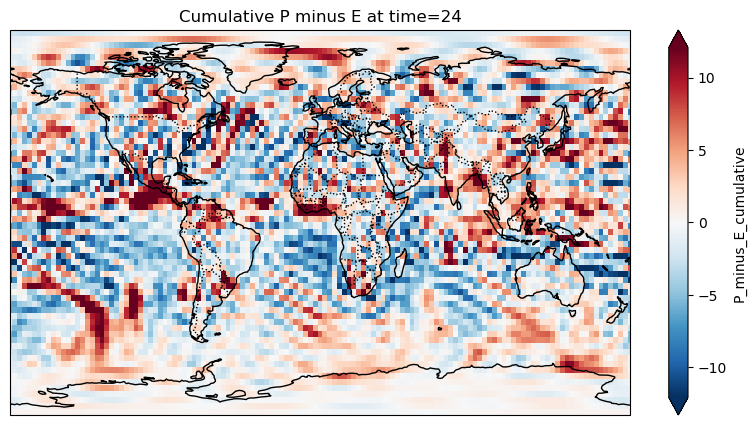

In [15]:
# Define the plot
import cartopy.crs as ccrs
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(10, 5))

# Plot the data
predictions_ds.P_minus_E_cumulative.sel(time=24).plot(
    x='longitude',
    y='latitude',
    robust=True,
    ax=ax,
    transform=ccrs.PlateCarree(),
    #aspect=2,
    #size=2
)

# Add cartographic features
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(cartopy.feature.LAND, edgecolor='black', facecolor='lightgray', alpha=0.5)

ax.set_aspect('auto')

# Customize the title and labels
ax.set_title("Cumulative P minus E at time=24", fontsize=12)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

## Data Analysis

In [16]:
#!pip install numpy==2.0
!pip install numba

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import norm
#from numba import jit

/home/lisa/anaconda3/envs/NeuralGCM/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [17]:
ersst_path = "./data/tos_Omon_GISS-E2-1-G_historical_r1i1p5f1_gn_200101-201412.nc"
ersst_data = xr.open_dataset(ersst_path)

## Temperature

In [18]:
predictions_ds['temperature'].sel(
    time=slice(outer_steps),
    latitude=lat_bounds,
    longitude=lon_bounds
).plot(x='longitude', y='latitude', row='time', col='model', robust=True, aspect=2, size=2)

NameError: name 'outer_steps' is not defined

In [ ]:
#predictions_ds['temperature']

## SST from NeuralGCM

In [22]:
outer_steps = 64

In [23]:
# Install and import necessary libraries
!pip install dask
import xarray as xr
#import dask

lat_bounds = slice(34, 51)  # Latitude bounds (51°N to 34°N)
lon_bounds = slice(-20, 10)  # Longitude bounds (-20°W to 10°E)

# Extract SST with lazy loading
sst = predictions_ds['temperature'].sel(
    time=slice(outer_steps),
    latitude=lat_bounds,
    longitude=lon_bounds)
print("1 done - SST extracted")

# Align time indexing for consistent processing
sst['time'] = sst.indexes['time']
print(sst)
print("done")

# Calculate climatological mean SST
climatological_mean_sst = sst.mean(dim='time').persist()  # Persist in memory for repeated use
print("2 done - Climatological mean computed")
print(climatological_mean_sst)
# Compute SST anomalies
sst_anomalies = (sst - climatological_mean_sst).persist()  # Persist anomalies for further analysis
print("3 done - SST anomalies computed")
print(sst_anomalies)

1 done - SST extracted
<xarray.DataArray 'temperature' (time: 3, level: 37, longitude: 4, latitude: 6)> Size: 11kB
Array([[[[260.84802, 263.63754, 259.475  , 256.51147, 262.5809 ,
          263.95566],
         [262.99152, 263.46118, 263.0076 , 258.83014, 262.8299 ,
          264.84067],
         [258.92145, 260.88675, 263.53592, 258.89832, 261.28973,
          264.1596 ],
         [258.69806, 260.9984 , 262.21634, 260.31924, 261.21414,
          264.97565]],

        [[259.50818, 261.97504, 257.29483, 253.92749, 259.46725,
          259.8913 ],
         [260.6535 , 262.18164, 259.56042, 258.6161 , 262.3845 ,
          262.2569 ],
         [256.91632, 261.7552 , 260.82602, 258.1268 , 260.96512,
          262.7291 ],
         [257.64865, 262.61014, 262.06516, 259.00824, 258.5446 ,
          264.1605 ]],

        [[255.023  , 255.65718, 251.37267, 249.93372, 253.71265,
          253.69536],
...
         [301.97836, 299.489  , 296.99557, 295.10043, 293.30988,
          292.16666]],

     

[[263.06778 262.75717 261.4613  259.6224  263.29523 265.7563 ]
 [263.66144 263.63464 263.5796  261.67844 263.98703 265.14877]
 [262.41806 263.49893 264.42917 262.345   263.3031  264.07657]
 [261.40945 263.45496 264.32858 264.41052 263.4265  264.3865 ]]
<xarray.DataArray 'temperature' (longitude: 4, latitude: 6)> Size: 96B
array([[301.0779 , 296.42526, 297.0552 , 294.2351 , 292.98502, 290.48306],
       [306.15457, 298.86044, 297.71008, 295.7679 , 295.33603, 291.2708 ],
       [306.3278 , 302.15543, 298.04977, 296.53024, 297.28186, 292.4397 ],
       [302.94507, 300.8245 , 298.51547, 297.1792 , 297.92493, 293.26782]],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float64 32B 0.0 2.812 5.625 8.438
  * latitude   (latitude) float64 48B 34.88 37.67 40.46 43.25 46.04 48.84
    level      int64 8B 1000
<xarray.DataArray 'level' (level: 37)> Size: 296B
array([   1,    2,    3,    5,    7,   10,   20,   30,   50,   70,  100,  125,
        150,  175,  200,  225,  250,  300,  350,

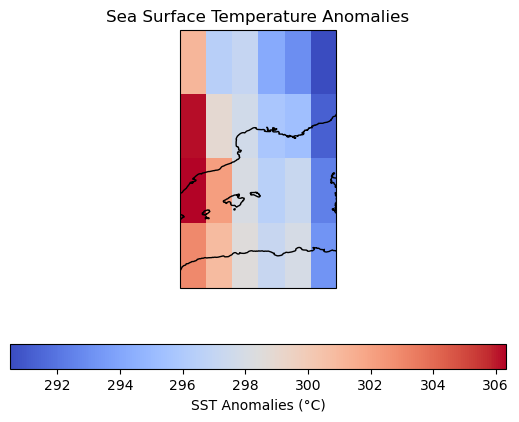

In [24]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
print(climatological_mean_sst.isel(level=0).values)
print(climatological_mean_sst.isel(level=-1))

print(climatological_mean_sst['level'])
# Subset the data
subset_sst = climatological_mean_sst.sel(latitude=lat_bounds, longitude=lon_bounds)

# Example for one time step
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
#ax.set_global()
ax.coastlines()
sst_plot = ax.imshow(
    subset_sst.isel(level=-1),
    extent=[
        subset_sst['longitude'].min(),
        subset_sst['longitude'].max(),
        subset_sst['latitude'].min(),
        subset_sst['latitude'].max(),
    ],
    transform=ccrs.PlateCarree(), cmap='coolwarm', origin='upper'
)



plt.colorbar(sst_plot, ax=ax, orientation='horizontal', label='SST Anomalies (°C)')
plt.title('Sea Surface Temperature Anomalies')
plt.show()

## SST Pattern  
<span style="color:green"></span> Compute anomalies, trends, or indices such as the Atlantic Multidecadal Oscillation (AMO) to understand SST variations over time. \

In [25]:
# Subset the data
lat_bounds = [slice(34, 45), slice(34, 51)] 
lon_bounds = [slice(-25, 19), slice(-20, 10)]  
start_time = '2005-01-01'
end_time = '2022-06-16'
sst_subset = ersst_data['tos'].sel(time=slice(start_time, end_time),
                                   lat=lat_bounds[0],
                                   lon=lon_bounds[0])
print(sst_subset.values)

# Calculate the climatology (mean over the period)
sst_subset['time'] = sst_subset.indexes['time']

climatology = sst_subset.mean(dim='time') 

print(climatology)
print(climatology.dims)
print(climatology.shape)
# Compute SST anomalies
sst_anomalies = sst_subset - climatology

sst_anomalies.to_netcdf('sst_anomalies.nc')

# Calculate the AMO index (example)
amo_index = sst_anomalies.mean(dim=['lat', 'lon'])

print(amo_index)

[[[       nan        nan        nan ... 17.161402  17.22317   17.031183 ]
  [16.820246  16.605341  16.54394   ... 16.665552  16.126245  16.093073 ]
  [15.9109745 16.127558  16.110926  ... 16.11056   15.816431  15.386805 ]
  [15.032404  14.926813  15.1045475 ... 15.282648  13.96673   14.784021 ]
  [       nan 14.09704   14.427637  ... 12.867334  13.254328  13.549036 ]
  [       nan        nan        nan ... 10.855951         nan        nan]]

 [[       nan        nan        nan ... 16.600336  16.717554  16.492823 ]
  [16.512873  16.13537   16.027826  ... 16.245935  15.773066  15.636133 ]
  [15.727381  15.836603  15.802759  ... 15.708582  15.480555  14.887781 ]
  [14.812159  14.666681  14.887079  ... 15.118921  13.488276  14.217493 ]
  [       nan 13.621759  14.30105   ... 12.288111  12.747187  13.042719 ]
  [       nan        nan        nan ... 10.951166         nan        nan]]

 [[       nan        nan        nan ... 16.27743   16.375025  16.16421  ]
  [16.551538  16.116693  15.899836

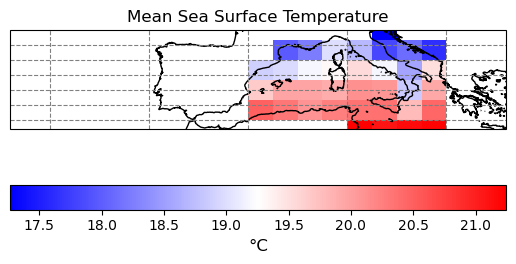

In [34]:
region = [-24, 26, 35, 45] 

plt.figure()
ax = plt.axes(projection=cartopy.crs.PlateCarree(central_longitude=0))
ax.set_global()
ax.set_extent(region, crs=cartopy.crs.PlateCarree())
ax.gridlines(linestyle='--',color='gray')
ax.coastlines()

temp_cartopy = ax.pcolormesh(
    sst_subset['lon'], 
    sst_subset['lat'], 
    climatology, 
    transform=cartopy.crs.PlateCarree(), 
    shading='auto', 
    cmap='bwr'
)
colorbar = plt.colorbar(temp_cartopy, ax=ax, orientation='horizontal', label='Mean Temperature')
colorbar.set_label("°C",size=12,rotation=0)
plt.title("Mean Sea Surface Temperature")
plt.show()

In [35]:
print(sst_anomalies.dims)
print(sst_anomalies)

('time', 'lat', 'lon')
<xarray.DataArray 'tos' (time: 120, lat: 6, lon: 8)> Size: 23kB
array([[[        nan,         nan,         nan, ..., -3.9139977 ,
         -3.9350433 , -4.191416  ],
        [-3.6703854 , -3.7083683 , -3.5631523 , ..., -3.6940918 ,
         -3.671362  , -4.3581963 ],
        [-3.7588577 , -3.835823  , -3.8574028 , ..., -3.9541893 ,
         -3.0226078 , -4.541548  ],
        [-3.8611698 , -4.0363636 , -4.079979  , ..., -3.9075336 ,
         -4.581421  , -4.7323666 ],
        [        nan, -3.8719711 , -3.8023014 , ..., -4.951601  ,
         -4.856676  , -4.0844955 ],
        [        nan,         nan,         nan, ..., -6.4079666 ,
                 nan,         nan]],

       [[        nan,         nan,         nan, ..., -4.4750633 ,
         -4.4406586 , -4.7297764 ],
        [-3.9777584 , -4.178339  , -4.0792656 , ..., -4.1137085 ,
         -4.024542  , -4.815136  ],
        [-3.9424515 , -4.1267776 , -4.1655693 , ..., -4.356167  ,
         -3.3584843 , -5.0405

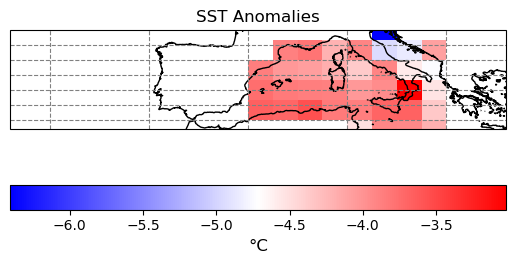

In [28]:
plt.figure()
ax = plt.axes(projection=cartopy.crs.PlateCarree(central_longitude=0))
ax.set_global()
ax.set_extent(region, crs=cartopy.crs.PlateCarree())
ax.gridlines(linestyle='--',color='gray')
ax.coastlines()

temp_cartopy = ax.pcolormesh(sst_subset['lon'], sst_subset['lat'], sst_anomalies[0,:,:], transform=cartopy.crs.PlateCarree(), shading='auto',cmap='bwr')
colorbar = plt.colorbar(temp_cartopy, ax=ax, orientation='horizontal', label='SST Anomalies')
colorbar.set_label("°C",size=12,rotation=0)
plt.title("SST Anomalies")
plt.show()

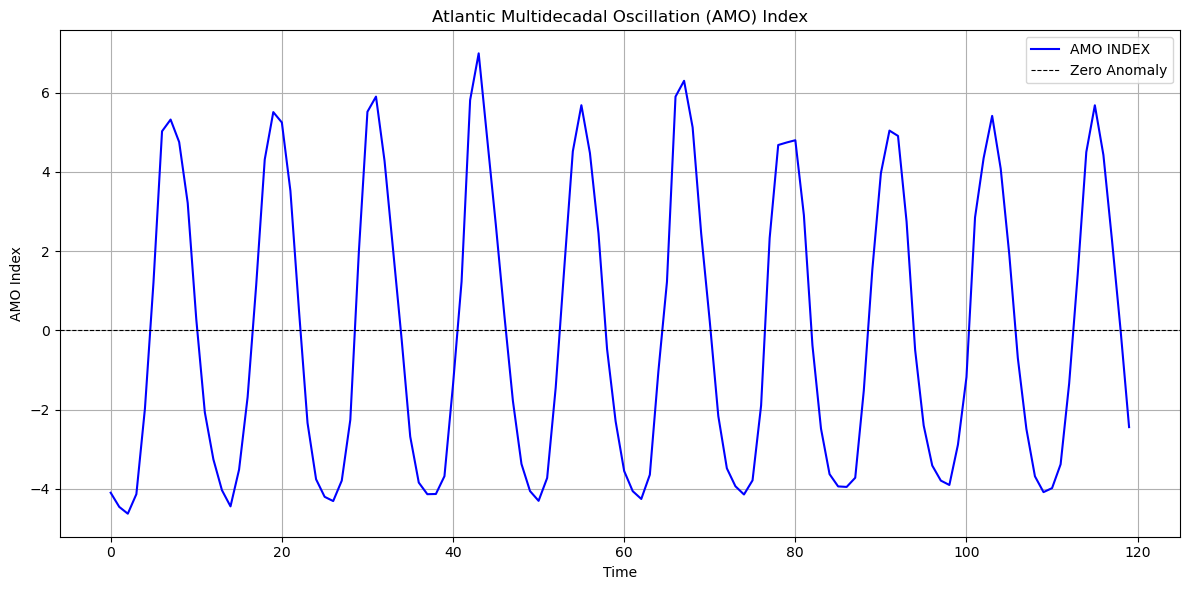

In [29]:
plt.figure(figsize=(12,6))
plt.plot(amo_index, label="AMO INDEX", color="b")
plt.axhline(0, color="k", linestyle="--", linewidth=0.8, label="Zero Anomaly")
plt.title("Atlantic Multidecadal Oscillation (AMO) Index")
plt.xlabel("Time")
plt.ylabel("AMO Index")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## RMSE SST
true values from file and predicted_values from neuralgcm

In [25]:
rmse = np.sqrt(np.mean((true_values - predicted_values) ** 2))

NameError: name 'true_values' is not defined

## SPEI

In [30]:
# Function to calculate SPEI directly 
def calculate_spei(predictions_ds, scale=3):
    import numpy as np
    import xarray as xr

    def thornthwaite(temp, lat):
        """
        Thornthwaite method to estimate potential evapotranspiration (PET).
        """
        temp_celsius = temp - 273.15  # Convert from Kelvin to Celsius
        if temp_celsius > 0:
            I = (temp_celsius / 5) ** 1.514
            a = (6.75e-7 * I ** 3) - (7.71e-5 * I ** 2) + (1.792e-2 * I) + 0.49239
            PET = 16 * ((10 * temp_celsius / I) ** a)  # Simplified Thornthwaite formula
        else:
            PET = 0  # PET is zero if temperature is below or equal to zero
    
        return PET



    def compute_spei(D, scale=3):
        """
        Compute Standardized Precipitation Evapotranspiration Index (SPEI) at a given scale.
        """
        rolling_mean = D.rolling(time=scale, center=False).mean()
        rolling_std = D.rolling(time=scale, center=False).std()
        spei = (rolling_mean - rolling_mean.mean(dim="time")) / rolling_std
        print("2")
        return spei

    # Step 1: Calculate PET
    latitude = predictions_ds['latitude']
    temperature = predictions_ds['temperature'].sel(level=1000)  # Near-surface temperature
    latitude_value = latitude.mean().item()  # Simplified to one value for now
    PET = xr.apply_ufunc(thornthwaite, temperature, latitude_value, vectorize=True)

# Calculate D
    P_minus_E = predictions_ds['P_minus_E_cumulative']
    D = P_minus_E - PET
# Compute SPEI
    SPEI = compute_spei(D, scale=scale)
    print("3")
    return SPEI

SPEI_result = calculate_spei(predictions_ds)
print(SPEI_result)
spei_avg = SPEI_result.mean(dim=['latitude', 'longitude'])
time = spei_avg['time']
spei_values = spei_avg.values

2
3
<xarray.DataArray (time: 64, longitude: 128, latitude: 64)> Size: 2MB
array([[[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,    

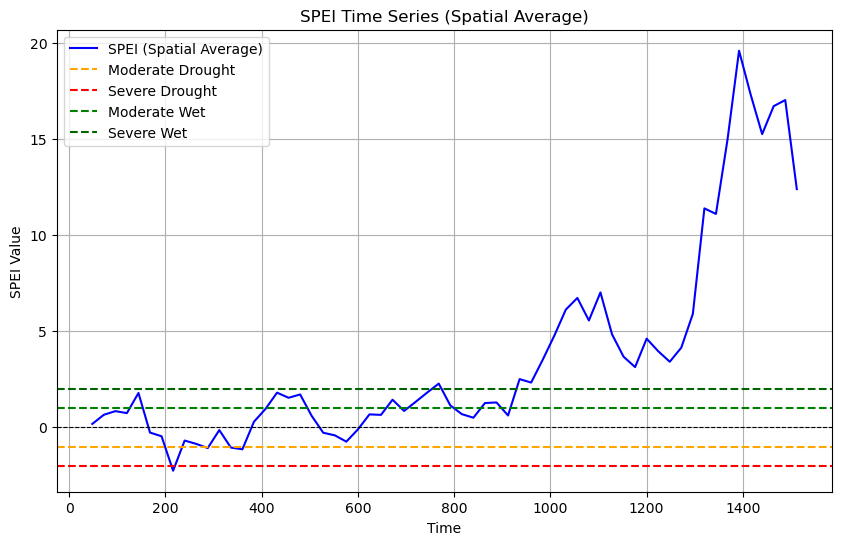

In [31]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(time, spei_values, label='SPEI (Spatial Average)', color='blue')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)  # Reference line for neutral SPEI
plt.axhline(-1, color='orange', linestyle='--', label='Moderate Drought')
plt.axhline(-2, color='red', linestyle='--', label='Severe Drought')
plt.axhline(1, color='green', linestyle='--', label='Moderate Wet')
plt.axhline(2, color='darkgreen', linestyle='--', label='Severe Wet')
plt.title("SPEI Time Series (Spatial Average)")
plt.xlabel("Time")
plt.ylabel("SPEI Value")
plt.legend()
plt.grid()
plt.show()

# Precipitation (Precipitation minus Evaporation)

TODO: check the month_average and the value ranges. Seem to be a bit off

In [302]:
reference_date = '2022-06-21'

In [321]:
#Resample values to month and weeks
precipitation = predictions_ds['P_minus_E_cumulative']
precipitation['time'] = pd.to_datetime(reference_date) + pd.to_timedelta(precipitation['time'].values, unit='h')

precipitation_month_average = precipitation.resample(time='1MS').mean(dim='time')
precipitation_week_average = precipitation.resample(time='1W').mean(dim='time')

print("Precipitation min:", precipitation.values.min())
print("Precipitation max:", precipitation.values.max())

print("Average Month min:",precipitation_month_average.values.min())
print("Average Week min:",precipitation_week_average.values.min())

print("Average Month max:",precipitation_month_average.values.max())
print("Average Week max:",precipitation_week_average.values.max())

Precipitation min: -634.71375
Precipitation max: 1042.8341
Average Month min: -494.49796
Average Week min: -628.3844
Average Month max: 868.9664
Average Week max: 1038.3479


In [313]:
region = [-24, 26, 35, 45]
longitude, latitude = np.meshgrid(precipitation['longitude'], precipitation['latitude'])
longitude = longitude.T
latitude = latitude.T

In [314]:
#use resampling for calculation for months
precipitation['month'] = precipitation['time'].dt.month 
precipitation['week'] = precipitation['time'].dt.isocalendar().week

months = np.unique(precipitation['time'].dt.month)
weeks = np.unique(precipitation['time'].dt.isocalendar().week)

print("Months: ", months)
print("Weeks: ", weeks)

Months:  [6 7 8]
Weeks:  [25 26 27 28 29 30 31 32 33 34]


In [318]:
#comute averages
month_average = [precipitation_month_average.isel(time=month) for month in range (len(months))]
week_average = [precipitation_week_average.isel(time=week) for week in range (len(weeks))]

month_names = [pd.to_datetime(f'2020-{month_number:02d}-01').strftime('%B') for month_number in months]
print(month_names)

['June', 'July', 'August']


In [320]:
print("Monthly Average (Spatial) Min/Max:")
print(f"Min={precipitation_month_average.min().values}, Max={precipitation_month_average.max().values}")
print("Sample Month Average Data:")
print(month_average[0])  # Check the first month
print(f"Min={month_average[0].min().values}, Max={month_average[0].max().values}")


Monthly Average (Spatial) Min/Max:
Min=-494.4979553222656, Max=868.9663696289062
Sample Month Average Data:
<xarray.DataArray 'P_minus_E_cumulative' (longitude: 128, latitude: 64)> Size: 33kB
array([[ 1.0666713 ,  2.6176276 ,  2.2360044 , ...,  1.9394207 ,
         0.8955744 ,  1.9973863 ],
       [ 0.9503525 ,  1.792338  ,  1.8970944 , ...,  1.307562  ,
         1.4931043 ,  1.5806468 ],
       [ 0.8328289 ,  0.9332582 ,  1.4795749 , ...,  0.4899598 ,
         2.1089222 ,  1.1619465 ],
       ...,
       [ 1.378001  ,  4.579866  ,  2.3838801 , ...,  2.5436656 ,
        -0.6722425 ,  3.2513452 ],
       [ 1.2833458 ,  4.038534  ,  2.515635  , ...,  2.5515845 ,
        -0.20144482,  2.8314426 ],
       [ 1.1786611 ,  3.3762074 ,  2.455296  , ...,  2.355009  ,
         0.32638827,  2.4138365 ]], dtype=float32)
Coordinates:
  * longitude  (longitude) float64 1kB 0.0 2.812 5.625 ... 351.6 354.4 357.2
  * latitude   (latitude) float64 512B -87.86 -85.1 -82.31 ... 82.31 85.1 87.86
    time  

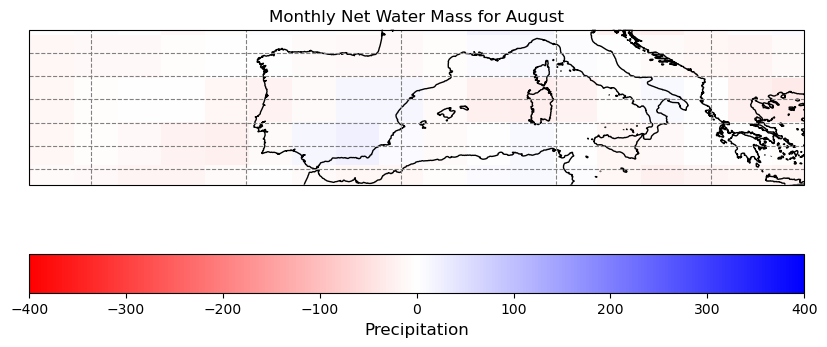

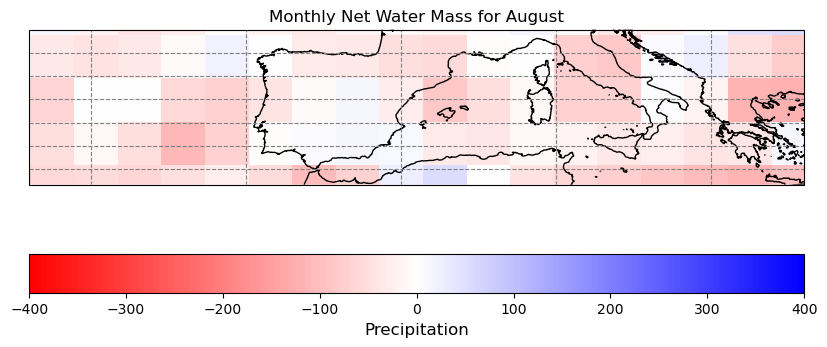

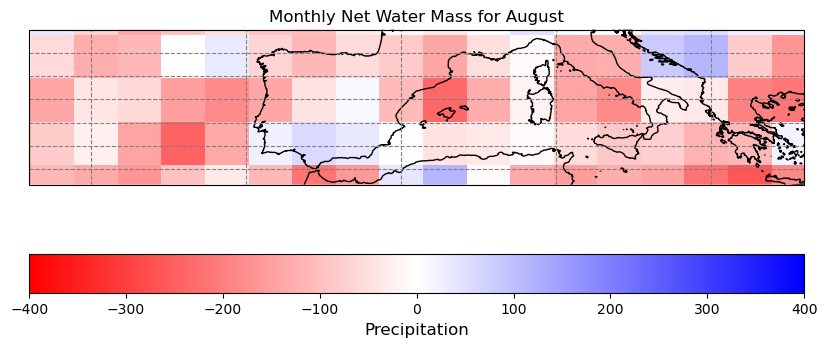

In [290]:
for i, month_number in enumerate(months):
    
    plt.figure(figsize=(10, 6))

    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent(region, crs=ccrs.PlateCarree())
    ax.gridlines(linestyle='--', color='gray')
    ax.coastlines()

    temp_cartopy = ax.pcolormesh(longitude, latitude, month_average[i], transform=cartopy.crs.PlateCarree(), shading='auto', cmap='bwr_r', vmin=-400, vmax=400)
    colorbar = plt.colorbar(temp_cartopy, ax=ax, orientation='horizontal', label='Precipitation')
    colorbar.set_label("Precipitation", size=12, rotation=0)

    plt.title(f"Monthly Net Water Mass for {month_name}")
    plt.show()

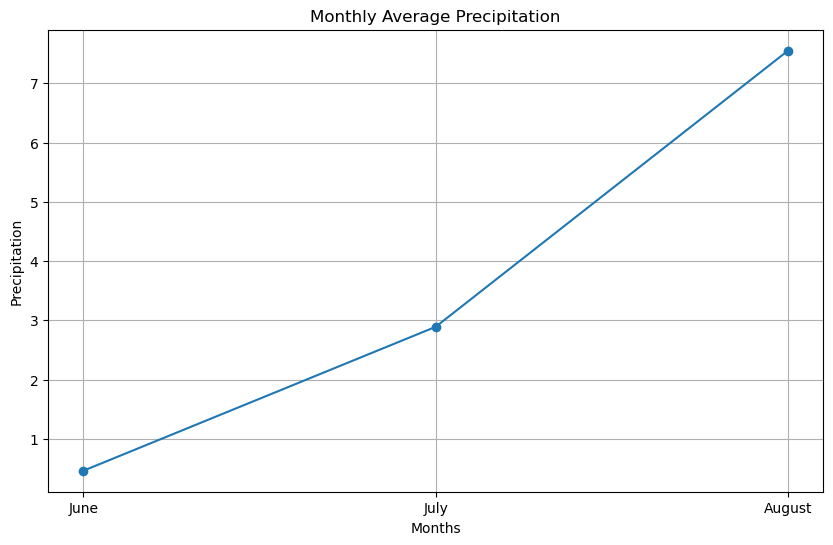

In [301]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(months)), precipitation_month_average.mean(dim=['latitude', 'longitude']), marker='o')
plt.title("Monthly Average Precipitation")
plt.xlabel("Months")
plt.ylabel("Precipitation")
plt.grid(True)
plt.xticks(
    range(len(month_names)),
    labels=month_names
)
plt.show()

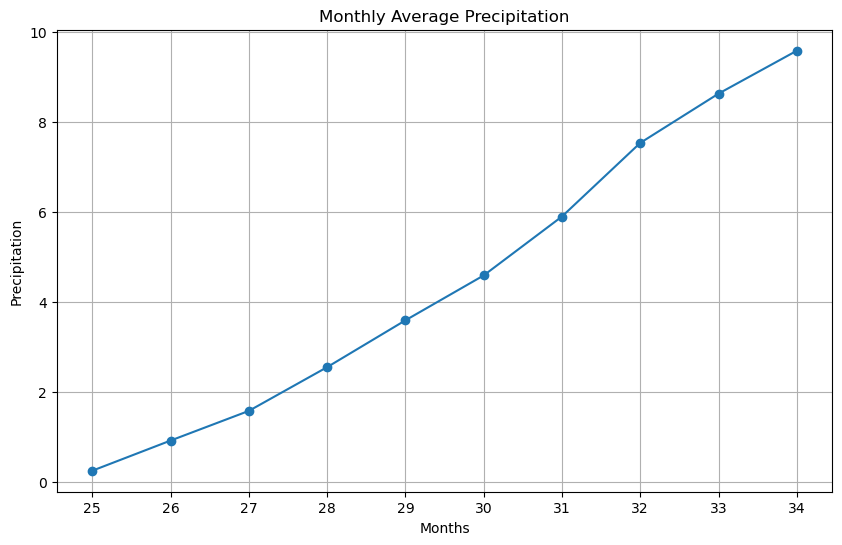

In [300]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(weeks)), precipitation_week_average.mean(dim=['latitude', 'longitude']), marker='o')
plt.title("Monthly Average Precipitation")
plt.xlabel("Months")
plt.ylabel("Precipitation")
plt.grid(True)
plt.xticks(
    range(len(weeks)),
    labels=weeks
)
plt.show()

# Drought severity

<span style='color:red'> ADD </span>

## Adding later

In [ ]:
from PIL import Image
from IPython.display import display

img = Image.open('images/Spain_range_1.png')
display(img)

In [ ]:
from PIL import Image
from IPython.display import display

img = Image.open('images/Spain_range_1.png')
display(img)

In [ ]:
img = Image.open('images/Spain_range_1.png')
display(img)

In [ ]:
#import signal
#import sys
#import numpy as np
#import jax
#
# Parameters for 30-year rollout
#years = 30
#days_per_year = 365  # Exclude leap years for simplicity
#inner_steps = 24  # Save model outputs every 24 hours
#hours_per_day = 24
outer_steps = (days_per_year * years * hours_per_day) // inner_steps  # Total steps for 30 years
timedelta = np.timedelta64(inner_steps, 'h')  # Time interval between model outputs
times = np.arange(outer_steps) * inner_steps  # Time axis in hours

# Placeholder model and data (replace with actual implementations)
# model = ...
# eval_era5 = ...

class GracefulExit:
    """Handles graceful exit and file closing."""
    def __init__(self, file):
        self.file = file
        self.is_running = True

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        self.cleanup()

    def cleanup(self):
        print("Shutting down gracefully...")
        if not self.file.closed:
            self.file.close()
        self.is_running = False

# Signal handler to trigger cleanup
def handle_signal(signum, frame):
    global graceful_exit_context
    graceful_exit_context.cleanup()

# Register signal handlers
signal.signal(signal.SIGINT, handle_signal)
signal.signal(signal.SIGTERM, handle_signal)

output_file = "30_year_rollout_predictions.nc"

with open(output_file, "w") as nc_file:
    with GracefulExit(nc_file) as graceful_exit_context:
        try:
            # Initialize model state
            print("Initializing model state...")
            inputs = model.inputs_from_xarray(eval_era5.isel(time=0))
            input_forcings = model.forcings_from_xarray(eval_era5.isel(time=0))
            rng_key = jax.random.key(42)  # Optional for deterministic models
            initial_state = model.encode(inputs, input_forcings, rng_key)

            # Use persistence for forcing variables (e.g., SST and sea ice cover)
            print("Using persistent forcing variables...")
            all_forcings = model.forcings_from_xarray(eval_era5.head(time=1))

            # Make forecast
            print(f"Starting 30-year rollout with {outer_steps} steps...")
            final_state, predictions = model.unroll(
                initial_state,
                all_forcings,
                steps=outer_steps,
                timedelta=timedelta,
                start_with_input=True,
            )

            # Convert predictions to xarray dataset
            print("Converting predictions to xarray.Dataset...")
            #print(predictions)
            predictions_ds = model.data_to_xarray(predictions, times=times)
            print(predictions_ds)
            # Save results to a NetCDF file
            print("Applying chunking to the dataset...")
            #chunked_ds = predictions_ds.chunk({'time': 100})  # Adjust chunk size as needed
            #chunked_ds.to_netcdf(output_file, mode='w', engine='netcdf4')


            # Final message
            print("30-year rollout completed successfully.")

        except Exception as e:
            print(f"An error occurred: {e}")
            graceful_exit_context.cleanup()
        finally:
            print("Execution stopped.")
